# TP4 : SUITE - Descente de gradient et débruitage d'une image en niveaux de gris

On récupère les données de la première partie du TP4

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.image as mpimg

# image
name = 'hibiscus256.bmp'
img0 = mpimg.imread(name)
n,N,a = img0.shape # n : nb de lignes et N : nb de colonnes

# signal
Sr = img0[50,:,0]/255
Sv = img0[50,:,1]/255
Sb = img0[50,:,2]/255
S = (Sr + Sv + Sb)/3

# variations 1D
def delta(V):
    return V[1:] - V[:-1]


## Exercice 4.- Descente de gradient pour le problème de débruitage 1D

On a à présent tous les outils permettant de résoudre numériquement le problème $(P)$ dans le cas $q =2$. On reprend nos signaux $S$ et $S_{noise}$ initiaux et on rappelle qu'on prendra $S_0 = S_{noise}$ dans le terme d'attache aux données de $(P)$.

In [6]:
noise = np.random.normal(0, 0.1, N)
Snoise = S + noise

1. Définir une fonction `gradE(V, lam)` qui prend en argument un `np.array V` et le paramètre `lam` ($\lambda$ dans le modèle) et renvoie $\nabla E(V)$.

*En reprenant le résultat obtenu à l'exercice $2$, on remarque que
$$
\nabla E(V) =  V - S_0 + \frac{\lambda}{2}\nabla J(V) \quad \text{et} \quad \frac{1}{2}\nabla J(V) = \left[ V_0 - V_1 \right. ,\underbrace{ - \delta(\delta V) }_{\in \mathbb{R}^{N-2}}, \left. V_{N-1} - V_{N-2} \right] \: ,
$$
où $\delta V$ a été défini à l'exercice $1$.*

2. Modifier la fonction `gradDescent` de l'exercice $3$ en une fonction `gradDescentParam(gradfun, lam, x0, nbIter, tau)` afin de prendre en compte le paramètre `lam` apparaissant dans $E$ et dans son gradient `gradE(V, lam)`.

3. On a établi dans l'exercice $2$ que la Hessienne de $E$ était $\displaystyle \nabla^2 E(V) = I_N + \lambda A$. On admettra que $A$ est une matrice symétrique positive dont les valeurs propres sont toutes dans $[0, 4]$. Pourquoi peut-on choisir un pas de temps $0 < \tau < \frac{2}{1 + 4 \lambda}$ ?

*On prendra par la suite un pas de temps $\displaystyle \tau = \frac{1.8}{1+4\lambda}$.*

4. Appliquer la descente de gradient `gradDescentParam` afin de résoudre numériquement le problème $(P)$, on partira de `x0 = Snoise`. On pourra choisir `nbIter = 50` et `lam = 4` (et `tau` adapté en fonction) pour ce premier test. Représenter et comparer le signal $S_{fin}$ ainsi obtenu avec $S$ et $S_{noise}$.

5. On s'intéresse à l'influence du paramètre $\lambda$. Conserver les même paramètres et faire varier `lam in np.arange(0,50,0.2)`. Pour chacune de ces valeurs de `lam`, calculer $S_{fin}$ (comme à la question précédente) puis $N_2 (\lambda) := \| S_{fin} - S \|_2$. Représenter $N_2(\lambda)$ en fonction de $\lambda$.

6. En déduire le choix de paramètre $\lambda$ qui semble optimal dans le cas présent (on "triche" ici : on connaît la solution $S$ qu'on veut retrouver). Pour la valeur du paramètre $\lambda > 0$ ainsi obtenue, représenter et comparer le signal $S_{fin}$ ainsi obtenu avec $S$ et $S_{noise}$. *On pourra utiliser la fonction `np.argmin`.* 

*Il est normal que la valeur de $\lambda$ "optimale" varie dès qu'on réexécute la première cellule de l'exercice :*

`noise = np.random.normal(0, 0.1, N)
Snoise = S + noise`

Vous devez obtenir des figures ressemblant aux figures suivantes pour le $\lambda$ optimal trouvé :

|   |   |
|---|---|
| ![](ex4fig1.png) | ![](ex4fig2.png) |

## Exercice 5.- Modèle variationnel pour débruiter une image

On reprend notre image initiale et on moyenne les 3 canaux RVB afin d'obtenir une image en niveaux de gris stockée dans le `np.ndarray U` de taille `n,N`, ici $n=N=256$. On génère ensuite une version bruitée en ajoutant à chaque pixel une v.a. suivant une loi normale centrée de variance $\sigma^2$ avec $\sigma = 0.1$. On obtient le `np.ndarray Unoise` de même taille que `U`.

Text(0.5, 1.0, 'Unoise')

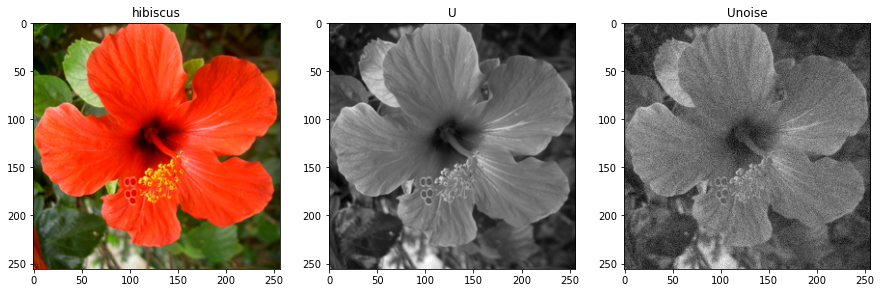

In [7]:
n,N,a = img0.shape # n : nb de lignes et N : nb de colonnes

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img0)
plt.title('hibiscus')

U = np.sum(img0, axis=2)/(3*255)
plt.subplot(1,3,2)
plt.imshow(U, cmap='gray')
plt.title('U')

noise = np.random.normal(0, 0.05, size=(n,N)) # sigma = 0.1
Unoise = U + noise

plt.subplot(1,3,3)
plt.imshow(Unoise, cmap='gray')
plt.title('Unoise')

Reprenons la démarche suivie pour aboutir au modèle $1D$ (début de l'exercice $1$). On se donne à présent $v : [0,1] \times [0,1] \rightarrow \mathbb{R}$ qu'on suppose être une version bruitée de notre image $u : [0,1] \times [0,1] \rightarrow \mathbb{R}$ qu'on ne connaît pas et qu'on souhaiterait "retrouver". 
Pour cela, on va à nouveau essayer de différencier (de façon quantitative) une image bruitée d'une image non bruitée en se basant sur les oscillations/variations : pour $q \geq 1$,
$$
\| \nabla v \|_{q}^q = \int_{[0,1] \times [0,1]} | \nabla v |^q = \int_{[0,1] \times [0,1]} \left(| \partial_x v |^2 + | \partial_y v|^2 \right)^\frac{q}{2}  \quad \text{sera plus grand pour } v \text{ que pour } u \: . 
$$
Du point de vue du signal discret, on peut remplacer $\partial_x v (x_i, y_j)$  par le taux de variation entre deux valeurs successives : supposons qu'on connaît

$$
V = \left[ v(x_i, y_j) \right]_{\substack{i = 0 \ldots N-1 \\ j = 0 \ldots n-1}} \in {\rm M}_{N,n}(\mathbb{R}) \quad \text{avec} \quad 0 = x_0 < x_1 < \ldots < x_{N-1} = 1 \quad \text{et} \quad 0 = y_0 < y_1 < \ldots < y_{n-1} = 1
$$
on peut remplacer $\partial_x v$ par la matrice des différences selon les abscisses $\delta^x V \in {\rm M}_{n,N-1}(\mathbb{R})$ :

$$ \begin{align*}
\delta^x V & = \left[ \begin{array}{cccc}
v(x_1, y_0) - v(x_0, y_0) & v(x_2, y_0) - v(x_1, y_0) & \ldots & v(x_{N-1}, y_0) - v(x_{N-2}, y_0) \\
v(x_1, y_1) - v(x_0, y_1) & v(x_2, y_1) - v(x_1, y_1) & \ldots & v(x_{N-1}, y_1) - v(x_{N-2}, y_1) \\
\vdots                     &      \vdots                &         &         \vdots                    \\           
v(x_1, y_{n-1}) - v(x_0, y_{n-1}) & v(x_2, y_{n-1}) - v(x_1, y_{n-1}) & \ldots & v(x_{N-1}, y_{n-1}) - v(x_{N-2} y_{n-1}) \\
\end{array} \right] \\
& = \left[ \begin{array}{cccc}
V_{0,1} - V_{0,0} & V_{0,2} - V_{0,1} & \ldots & V_{0,{N-1}} - V_{0,{N-2}} \\
V_{1,1} - V_{1,0} & V_{1,2} - V_{1,1} & \ldots & V_{1,{N-1}} - V_{1,{N-2}} \\
\vdots                     &      \vdots                &         &         \vdots                    \\     
V_{n-1,1} - V_{n-1,0} & V_{n-1,2} - V_{n-1,1} & \ldots & V_{n-1,N-1} - V_{n-1,N-2} \\
\end{array} \right] = \left[ \begin{array}{c|c|c|c}
V_{\cdot, 1} - V_{\cdot, 0} & V_{\cdot, 2} - V_{\cdot, 1} & \ldots & V_{\cdot,{N-1}} - V_{\cdot,{N-2}} \\
\end{array} \right] 
\end{align*}
$$

On a utilisé les notations $V_{i, \cdot}$ pour désigner la ligne $i$ de $V$ et $V_{\cdot, j}$ pour désigner la colonne $j$ de $V$.


On peut de même remplacer $\partial_y V$ par la matrice des différences selon les ordonnées $\delta^y V \in {\rm M}_{n-1,N}(\mathbb{R})$ :

$$
\delta^y V =
\left[ \begin{array}{cccc}
V_{1,0} - V_{0,0} & V_{1,1} - V_{0,1} & \ldots & V_{1,N-1} - V_{0,N-1} \\
V_{2,0} - V_{1,0} & V_{2,1} - V_{1,1} & \ldots & V_{2,N-1} - V_{1,N-1} \\
\vdots                     &      \vdots                &         &         \vdots                    \\     
V_{n-1,0} - V_{n-2,0} & V_{n-1,1} - V_{n-2,1} & \ldots & V_{{n-1},N-1} - V_{{n-2},N-1} \\
\end{array} \right] = \left[ \begin{array}{c}
V_{1,\cdot} - V_{0,\cdot}  \\
\hline
V_{2,\cdot} - V_{1,\cdot} \\
\hline
\vdots                                      \\
\hline
V_{n-1,\cdot} - V_{n-2,\cdot} \\
\end{array} \right] 
$$

On peut alors remplacer $\| \nabla v \|_{q}^q$ par 

$$
\begin{align*}
J(V) & = \sum_{i,j} \left( | (\delta^x V)_{i,j} |^2 + | (\delta^y V)_{i,j}|^2 \right)^\frac{q}{2} \\
& = \sum_{i=1}^{N-1} \sum_{j=1}^{n-1} \left( | V_{i,j} - V_{i-1,j}|^2 + | V_{i,j} - V_{i,j-1}|^q \right)^\frac{q}{2}  + \sum_{j = 1}^{n-1} | V_{0,j} - V_{0,j-1}|^q + \sum_{i=1}^{N-1} | V_{i,0} - V_{i-1,0}|^q \: .
\end{align*}
$$

Pour $q=2$, on peut en déduire facilement/fastidieusement le gradient de $J$, similairement à ce qui a été fait dans le cas d'un signal $1D$.

1. Effectuer le calcul de $\nabla J(V)$ et vérifier qu'on peut alors réécrire, 
$$
\frac{1}{2} \nabla J(V)= - \delta^x \left( \left[ 
\begin{array}{c|c|c}
0 &                              & 0 \\
\vdots & (\delta^x V) & \vdots \\
0     &                          & 0
\end{array} \right] \right) - \delta^y \left( \left[ 
\begin{array}{ccc}
0 & \ldots & 0 \\
\hline 
&  (\delta^y V) &  \\
\hline 
0 & \ldots & 0
\end{array} \right] \right)
$$

2. Définir des fonctions `deltax` et `deltay` qui prennent en argument un `np.ndarray V` de taille `n,N` et renvoient respectivement le `np.ndarray` $\delta^x V$ de taille `n,N-1` et le `np.ndarray` $\delta^y V$ de taille `n-1,N`. Grâce à l'écriture ci-dessus du gradient (question $1$), définir une fonction `gradEMat(V,lam)` qui renvoie le gradient de 
$$
E(V) = \frac{1}{2} \| V - U_{noise} \|_2^2 + \frac{\lambda}{2} J(V) \: .
$$

3. Utiliser la fonction `gradDescentParam` implémentée précédemment afin d'obtenir une solution approchée `Ufin` au problème de minimsation de $E$ en partant de `x0 = Unoise`. On pourra commencer par tester avec $\lambda = 2$, $\displaystyle \tau = \frac{1.8}{1+8\lambda}$ et $100$ itérations.

4. Représenter l'image `Ufin` obtenue à la question précédente et la comparer avec `U` et `Unoise`, on pourra comparer quelques fenêtres de zoom. 

5. Jouer sur les différents paramètres et comparer les résultats obtenus.

Vous devriez obtenir des résultats comparables à

![](ex5fig1.png)
![](ex5fig2.png)
![](ex5fig3.png)

## Exercice 6.- L'effet du régularisateur ${\rm L}^2$ 

On va essayer d'étudier l'effet du choix de "régularisation" $J = J_2$. On remarque tout d'abord que la méthode de débruitage mise en oeuvre dans l'exercice précédent produit un floutage des contours présents dans l'image. On va le vérifier dans les questions $1$ et $2$ suivantes. 

1. Appliquer la descente de gradient à l'énergie modifée
$$
\tilde{E} (V) = \frac{1}{2} \| V - U \|_2^2 + \frac{\lambda}{2} J(V)
$$
où on a remplacé `Unoise` par `U` dans le terme d'attache aux données afin d'observer uniquement l'effet de $J_2$. On partira de `x0 = U` directement, en conservant les paramètres $\lambda = 2$, $\displaystyle \tau = \frac{1.8}{1+8\lambda}$. Comparer les résultats après $10$ itérations et après $100$ itérations avec l'image `U`.

2. Effectuer la même expérience qu'à la question $1$, en remplaçant `U` par l'image plus simple `Inb` définie ci-dessous.

In [8]:
"""
Inb = np.zeros((256,256))
for i in range(100,150):
    for j in range(50,200):
        Inb[i,j] = 1
#plt.imshow(Inb, cmap='gray')
"""

"\nInb = np.zeros((256,256))\nfor i in range(100,150):\n    for j in range(50,200):\n        Inb[i,j] = 1\n#plt.imshow(Inb, cmap='gray')\n"

3. On revient dans cette question à un signal 1D très simple : reprendre à nouveau la question 1 en remplaçant l'image `U`par le signal `Sgeom` défini ci-dessous. Représenter le signal `Sgeom` et les signaux `S10` et `S50` obtenus après $10$ itérations et $50$ itérations de descente de gradient.

*Plus précisément, on reprendra le gradient de E avec paramètre $\lambda$ : `gradE(V, lam)` défini à la question $1$ de l'exercice $4$ et on remplacera `Snoise` par `Sgeom` dans le terme d'attache aux données. On effectuera ensuite la descente de gradient grâce à `gradDescentParam` (exercice $4$ question $2$) en prenant `x0 = Sgeom`, $\lambda = 10$, $\tau = \displaystyle \frac{1.8}{1+4\lambda}$ et `nbIt = 10` puis `nbIt = 50`.*

In [9]:
"""
t01 = np.linspace(0,1,256)
Sgeom = (t01>0.5)**np.ones(256)
plt.figure()
plt.plot(t01,Sgeom, 'black', label = u'$S_{geom}$')
"""

"\nt01 = np.linspace(0,1,256)\nSgeom = (t01>0.5)**np.ones(256)\nplt.figure()\nplt.plot(t01,Sgeom, 'black', label = u'$S_{geom}$')\n"

Vous devriez obtenir des figures comparables à

|   |   |   |
|---|---|---|
| ![](ex6fig2.png) | ![](ex6fig3.png) | ![](ex6fig1.png) |

*On observe que la transition $0$-$1$ est régularisée lorsqu'on minimise $E$ pour $q = 2$.
rappelons à présent que dans l'exercice $1$, on avait proposé un terme de régularisation de la forme
$$
J_q(S) = \| \delta S \|_q^q
$$
et on avait observé que plus $q$ était proche de $1$, plus $J_q(S) - J_q(S_{noise})$ était grand ce qui donne envie de considérer $q = 1$. Cependant, le choix $q = 2$ était également naturel car simple à mettre en oeuvre :  le gradient de $J_2$ est assez simple à exprimer, ce qui permet d'utiliser une descente de gradient comme on l'a fait jusqu'ici.*

4. Calculer et comparer $J_q$ pour $q = 1$ et $q = 2$ pour chacun des trois signaux `Sgeom`, `S10` et `S50` représentés à la question $3$. En ce qui concerne les valeurs obtenues pour $J_1$, justifiez les résultats obtenus par un calcul théorique.

*On observe ainsi que contrairement à $J_2$, le terme $J_1$ ne tend pas à régulariser les transitions brutales, et on pourrait vérifier que de même $J_1$ ne tend pas à flouter les contours présents dans une image (ces contours correspondent aux lignes de transition brutale entre deux teintes de gris différentes).*


## Exercice 7.- Modèle ${\rm TV}$ - ${\rm L}^2$ régularisé

On revient au choix $q = 1$. Notons tout d'abord une obstruction importante : $J_1$ n'est pas différentiable et la mise en oeuvre de la descente de gradient n'est plus possible. Pour $V \in \mathbb{R}^N$,
$$
J_1 (V) = \sum_{i=1}^{N-1} | V_i - V_{i-1} | \: 
$$
n'est pas différentiable en tout point $V$ tel que $\exists k$, $V_k = V_{k-1}$. Afin de contourner cette obstruction, on propose de remplacer $|t|$ par $\sqrt{\epsilon^2 + t^2}$, et ainsi considérer pour régulariser le signal $S_{noise}$ :
$$
E_\epsilon (V) = \frac{1}{2} \| V - S_{noise} \|_2^2 + \lambda J_\epsilon (V) \quad \text{avec} \quad J_\epsilon(V) = \sum_{i=1}^{N-1} \sqrt{ \epsilon^2 + | V_i - V_{i-1} |^2 } = \sum_{k=i}^{N-2} \sqrt{ \epsilon^2 + | (\delta V)_{i} |^2 }  \: ,
$$
ou encore pour régulariser l'image $U_{noise}$ :
$$E_\epsilon (V) = \frac{1}{2} \| V - U_{noise} \|_2^2 + \lambda J_\epsilon (V) \quad \text{avec} \quad J_\epsilon(V) = 
\sum_{i,j} \sqrt{\epsilon^2 + | (\delta^x V)_{i,j} |^2 + | (\delta^y V)_{i,j}|^2 } \: .
$$

1. On définit pour $\epsilon > 0$, $h_\epsilon : \mathbb{R} \rightarrow \mathbb{R}_+$, $t \mapsto \sqrt{\epsilon^2 + t^2}$. Représenter le graphe de $h_\epsilon$ sur $[-2,2]$ pour $\epsilon \in \{1, 0.1, 0.01\}$. Calculer $h_\epsilon^\prime$ et représenter également son graphe.

2. Soit $i,k \in \{0, 1, \ldots, N-1\}$, vérifier que
$$
\partial_k \left[ h_\epsilon(V_i - V_{i-1}) \right] = \left\lbrace \begin{array}{ccc}
h_\epsilon^\prime (V_k - V_{k-1}) & \text{si} & i = k \\
-h_\epsilon^\prime (V_{k+1} - V_{k})  & \text{si} & i = k+1 \\
0 & \text{sinon} &
\end{array}\right. \: .
$$
En déduire que pour $0< k < N-1$,
$$
\partial_k J_\epsilon (V) = h_\epsilon^\prime (V_k - V_{k-1}) - h_\epsilon^\prime (V_{k+1} - V_{k}) \quad \text{et} \quad \partial_0 J_\epsilon(V) = -h_\epsilon^\prime (V_1 - V_0) \quad \text{et} \quad \partial_{N-1} J_\epsilon(V) =  h_\epsilon^\prime ( V_{N-1} - V_{N-2}) \: .
$$


3. Fixer $\epsilon = 0.01$ et implémenter une fonction `gradEeps(V)` qui prend en argument un `np.array V` et retourne $\nabla E_\epsilon (V)$ où $E_\epsilon(V) = \frac{1}{2}\| V - S_{noise} \|_2^2 + \lambda J_\epsilon(V)$.

*On pourra utiliser la question $2$ pour réécrire
$$
\nabla J_\epsilon(V) = -\delta W \quad \text{où} \quad W = 
\left[ 0 \right. ,\underbrace{h_\epsilon^\prime ( (\delta V)_1 ) ,  h_\epsilon^\prime ( (\delta V)_2 ) , \ldots , h_\epsilon^\prime ( (\delta V)_{N-2} )  }_{\in \mathbb{R}^{N-2}}, \left. 0 \right] \: ,
$$
où $\delta V$ a été défini à l'exercice $1$.*

4. Appliquer la descente de gradient avec $\lambda = 0.2$, $\tau = \displaystyle \frac{1.8}{1 + 4 \frac{\lambda}{\epsilon}}$, en partant de `x0 = Snoise` et en effectuant $200$ itérations. Comparer avec le signal obtenu en minimisant $E = E_2$ dans l'exercice $4$.

Vous devriez obtenir des résultats comparables à

![](ex7fig1.png)

5. On va terminer ce travail en menant à bien la minimisation de
$\displaystyle
E_\epsilon(V) = \frac{1}{2} \| V - U_{noise} \|_2^2 + \lambda J_\epsilon(V)$ avec $\displaystyle h_\epsilon(t_1,t_2) = \sqrt{\epsilon^2 + t_1^2 + t_2^2}$ et
$$
\begin{align*}
J_\epsilon (V) & = \sum_{i,j} h_\epsilon \left((\delta^x V)_{i,j} , (\delta^y V)_{i,j} \right) \\
& = \sum_{i=1}^{N-1} \sum_{j=1}^{n-1}  h_\epsilon \left(   V_{i,j} - V_{i,j-1} , V_{i,j} - V_{i-1,j} \right)  + \sum_{j = 1}^{n-1} h_\epsilon \left(  V_{0,j} - V_{0,j-1}, 0 \right) + \sum_{i=1}^{N-1} h_\epsilon \left( 0, V_{i,0} - V_{i-1,0} \right) \: .
\end{align*}
$$
On conserve $\epsilon = 0.01$ et on admettra que le gradient de $E_\epsilon$ peut-être implémenté comme suit par la fonction `gradETV(V,lam)`. Appliquer la descente de gradient afin de minimiser $E_\epsilon$, on prendra $\lambda = 0.05$, $\tau = \displaystyle \frac{1.8}{1+8\frac{\lambda}{\epsilon}}$, `X0 = Unoise` et $300$ itérations. Comparer avec les résultats obtenus à la fin de l'exercice $5$. *Vérifier qu'on obtient des contours plus nets dans l'image.*

In [10]:
"""
eps = 0.01

def gradETV(V, lam):
    n,N = V.shape
    W1 = np.zeros((n,N))
    W2 = np.zeros((n,N))
    dx = deltax(V); dy = deltay(V)
    W1[:, :-1] = dx
    W2[:-1, :] = dy
    Neps = np.sqrt(eps**2 + W1**2 + W2**2)
    #
    W3 = np.zeros((n,N+1))
    W4 = np.zeros((n+1,N))
    W3[:, 1:-1] = dx/Neps[:, :-1]
    W4[1:-1, :] = dy/Neps[:-1, :]
    W = -deltax(W3) - deltay(W4)
    return V - Unoise + lam*W
"""

'\neps = 0.01\n\ndef gradETV(V, lam):\n    n,N = V.shape\n    W1 = np.zeros((n,N))\n    W2 = np.zeros((n,N))\n    dx = deltax(V); dy = deltay(V)\n    W1[:, :-1] = dx\n    W2[:-1, :] = dy\n    Neps = np.sqrt(eps**2 + W1**2 + W2**2)\n    #\n    W3 = np.zeros((n,N+1))\n    W4 = np.zeros((n+1,N))\n    W3[:, 1:-1] = dx/Neps[:, :-1]\n    W4[1:-1, :] = dy/Neps[:-1, :]\n    W = -deltax(W3) - deltay(W4)\n    return V - Unoise + lam*W\n'

6. Représenter (par une image) $\nabla E_\epsilon(U_{noise})$ et $\nabla E_2(U_{noise})$ en utilisant les paramètres ayant servis pour les calculs numériques dans la question précédente/dans la question $3$ de l'exercice $5$.